In [ ]:
import random
import copy
import numpy as np
import theano as T
import theano.tensor as tt
import pymc3 as pm
import pandas as pd
import rpy2
from rpy2.robjects import pandas2ri
pandas2ri.activate()
%load_ext rpy2.ipython


In [2]:
%%capture  --no-stderr --no-stdout --no-display
%%R

library(ggplot2)
library(reshape)
library(grid)
library(dplyr)
library(gridExtra)
library(lme4)

paper_theme_2 <- theme_light() + theme(axis.title.x = element_text(size=18),
  axis.text.x=element_text(colour="black", 
                           size = 14), 
  axis.title.y = element_text(size = 18, vjust = 1),
  axis.text.y  = element_text(size = 14, colour="black"),
 title =element_text(size=16, face='bold'))

paper_theme_3 <- theme( axis.title.x = element_text(size=18),
  axis.text.x=element_text(colour="black", 
                           size = 14), 
  axis.title.y = element_text(size = 18, vjust = 1),
  axis.text.y  = element_text(size = 14),
  strip.text=element_text(size=16),
  axis.line.x = element_line(colour = "black"), 
  axis.line.y = element_line(colour = "black"),
  legend.title=element_text(size=18),
  legend.text=element_text(size=16))  

  

/usr/local/lib/python3.5/dist-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Need help getting started? Try the cookbook for R:
http://www.cookbook-r.com/Graphs/

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.5/dist-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: 
Attaching package: ‘dplyr’


  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.5/dist-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: The following object is masked from ‘package:reshape’:

    rename


  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.5/dist-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: The following objects are masked from ‘package:stats’:

    filter, lag


  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.5/dist-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/pyth

In [171]:
%%R --o data_resp
data_resp_loc <- read.csv("r_data/r_resp_500.csv")

#data_resp_loc <- read.csv("data/estimation_dot_gaze.csv", sep="\t")
data_tracker <- read.csv("data/estimation_tracker_data.csv", sep="\t")
data_tracker$trial_id <- data_tracker$trial_id - 1
data_resp_loc$trial_id <- data_resp_loc$trial_id - 1


data_resp_loc <- data_resp_loc %>%
                filter(belowX >=0) 
                #mutate(belowX=max(0.1,belowX))

trials <- (unique(data_resp_loc$trial_id))

data_tracker <- data_tracker %>%
                group_by(trial_id) %>%
                filter(trial_id %in% trials)


data_resp_loc$id <- seq.int(1, nrow(data_resp_loc))


data_resp <- data_resp_loc %>%
      filter(gazeDist > 0 & Dots_Shown < 150 & Dots_Shown >= 10) %>%
             mutate(Subject=as.factor(Subject)) %>%

            group_by(Time) %>%
            #mutate(Time = as.factor(round(Time, 2))) %>%
             group_by(Subject,trial_id) %>%
             mutate(mean_dist=mean(mean_dist)) %>%

             mutate(n_in_fovea = (p_foveal > 1) )%>%
             mutate(belowX=mean(n_in_fovea)) %>%
             mutate(n_within_gaze = sum(n_in_fovea)) %>%
             mutate(p_within_gaze = n_within_gaze/Dots_Shown) %>%
            mutate(time_num = as.numeric(as.character(Time))) %>%
            mutate(err=Dots_Counted-Dots_Shown) %>%
              mutate(pct_err=err/Dots_Shown) %>%
             mutate(within_x=p_within_gaze) %>%
            mutate(within_x_tot=n_within_gaze)%>%
            mutate(fix_PL = mean(fix_PL)) %>%
            mutate(area=mean(area)) %>%
             top_n(n=1, wt=id) %>%
            group_by(Time) %>%
         filter((pct_err < 2)) %>%
            group_by(Subject) %>%
            mutate(mean_fix_PL = mean(fix_PL)) %>%
          mutate(pathLength=mean(fix_PL)) %>%
          mutate(medFix = mean(medFix)) %>%
          mutate(mean_PL=mean(fix_PL)) %>%
          mutate(mean_area=mean(area)) %>%
          #mutate(mean_dist=sum(gazeDist)/Dots_Shown) %>%
          mutate(err=Dots_Counted - Dots_Shown) %>%
          mutate(abs_err=abs(err)) %>%
          mutate(mean_abs_err = mean(abs_err)) %>%
          mutate(pct_err=err/Dots_Shown) %>%
            mutate(abs_pct_err=abs_err/Dots_Shown) %>%
         # filter(abs_pct_err <= 1.) %>%
          #group_by(Subject, pid)%>%
          #filter(length(Subject) > 0)  %>%
          group_by(Subject, pid, Time) %>%
          #  mutate(outlier= mean(mean_dist) + 2.5*sd(mean_dist)) %>%

          mutate(n_seen = n())# %>%
           # rowwise() %>%
          #  filter(mean_dist < outlier)
         #filter(Time == 0.1)
print(nrow(data_resp))


data_tracker <- data_tracker %>%
                  filter(ValidityLeft == 0 & ValidityRight == 0) %>%

                mutate(av_x = (GazePointXLeft +GazePointXRight)/2) %>%
                mutate(av_y = (GazePointYLeft +GazePointYRight)/2) %>%
                group_by(trial_id) %>%
                mutate(Time = round(max(TimeStamp)/100)/10)

data_tracker$id <- seq.int(1,nrow(data_tracker))

data_resp$Time <- as.factor(round(data_resp$Time,2))

print(table(data_resp$pid, data_resp$n_seen))




[1] 1656
    
     13 14 15 16
  0   0  0  0 64
  1   0  0  0 64
  2   0  0  0 64
  3   0  0  0 64
  4   0  0  0 64
  5   0  0  0 64
  6   0  0  0 64
  7  13  0  0 48
  8   0  0  0 64
  9   0  0 15 48
  10  0  0  0 64
  11  0  0  0 64
  12  0  0 15 48
  13  0  0  0 64
  14  0  0  0 64
  15  0  0  0 64
  16  0  0  0 64
  17  0  0  0 64
  18  0  0  0 64
  19  0  0  0 64
  20  0  0 15 48
  21  0 14  0 48
  22  0  0  0 64
  23  0  0  0 64
  24  0  0  0 64
  25  0  0  0 64



Call:
lm(formula = pct_err ~ p_within_gaze * time_num, data = data_resp)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.57208 -0.19441 -0.03904  0.13672  1.75381 

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)            -0.28591    0.01274 -22.446  < 2e-16 ***
p_within_gaze           0.51335    0.15084   3.403 0.000682 ***
time_num                0.04044    0.01283   3.152 0.001651 ** 
p_within_gaze:time_num -0.16158    0.06006  -2.690 0.007211 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.2797 on 1652 degrees of freedom
Multiple R-squared:  0.02916,	Adjusted R-squared:  0.0274 
F-statistic: 16.54 on 3 and 1652 DF,  p-value: 1.365e-10


Call:
lm(formula = pct_err ~ p_within_gaze + Dots_Shown, data = data_resp)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.49788 -0.17185 -0.02982  0.10596  1.87377 

Coefficients:
                Estimate Std. Error t value Pr(>

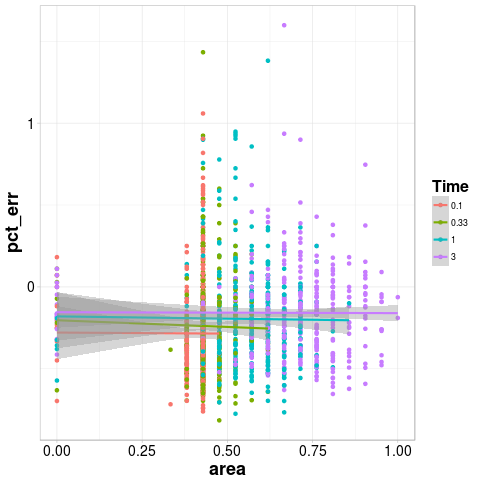

In [172]:
%%R

p.1 <- ggplot(data=data_resp, aes(x=area, y=pct_err, color=Time)) +
        geom_point() +
        stat_smooth(method="lm") +
        paper_theme_2
        
r.1 <- lm(data=data_resp, pct_err ~ p_within_gaze*time_num)
r.2 <- lm(data=data_resp, pct_err ~ p_within_gaze+Dots_Shown)

print(p.1)
print(summary(r.1))
print(summary(r.2))


In [173]:
data_resp = pandas2ri.ri2py(data_resp)

In [198]:
def remove_n(ls,n):
    ret = []
    for l in ls:
        l_rem = l[:n]
        ret.append(l_rem)
    return ret


subj_group = data_resp.groupby(["pid", "Subject"])
#subj_group = data_resp.groupby(["pid", "Subject"])

#subj_group = data_resp.groupby(["Time"])

dots_shown,dots_counted,mean_dist,seen,n_look,times, pid,area, fix_PL=[],[],[],[],[],[], [],[],[]
for i,subj in subj_group:
    area.append(list(subj["area"]))
    fix_PL.append(list(subj["fix_PL"]))

    times.append([float(i) for i in list(subj["Time"])])
    dots_shown.append(list(subj["Dots_Shown"]*1.))
    dots_counted.append(list(subj["Dots_Counted"]*1.))
    mean_dist.append(list(subj["mean_dist"] * 0.95))
    seen.append(list(subj["within_x_tot"]*1.))
    n_look.append(list(subj["nLooks"]))
    pid.append(list(subj["Subject"]))

ns = [len(n) for n in seen]
min_n = min(ns)

print (ns)
print(min_n)

dots_shown = remove_n(dots_shown, min_n)
dots_counted = remove_n(dots_counted, min_n)
mean_dist = remove_n(mean_dist, min_n)
seen = remove_n(seen, min_n)
n_look = remove_n(n_look, min_n)
times = remove_n(times, min_n)
pid = remove_n(pid, min_n)
area = remove_n(area, min_n)
fix_PL = remove_n(fix_PL, min_n)


dots_shown=np.array(dots_shown)
dots_counted=np.array(dots_counted)
mean_dist=np.array(mean_dist)
seen=np.array(seen)
n_look = np.array(n_look)
times = np.array(times)
unseen = dots_shown - seen
pid = np.array(pid)
fix_PL = (np.array(fix_PL) - np.mean(fix_PL))/np.std(fix_PL)
area = np.array(area)



with pm.Model() as mod:


    #beta_grp_sd = pm.HalfNormal("slope_grp_sd", sd=4,testval=2)
    #weber_grp_sd = pm.HalfNormal("weber_grp_sd",sd=1,testval=0.25)
    

    #slope = pm.HalfNormal("slope", sd=5, shape=(len(dots_shown), 1))
    #inv_weber = pm.HalfNormal("inv_weber", sd=100, shape=(len(dots_shown), 1), testval=4)
    #weber = pm.Deterministic("weber", 1/inv_weber)

    #guess_mean = dots_shown * slope  #unseen_slope * unseen
    #guess_sd = guess_mean * weber

    
    slope_grp_mu = pm.Normal("grp_slope_mu", mu=0, sd=5,testval=0)
    seen_slope_grp_mu = pm.Normal("seen_grp_slope_mu",mu=0, sd=10,testval=0.0)
    #time_slope_grp_mu = pm.Normal("time_grp_slope_mu",mu=0, sd=10,testval=0.0)
   
    noise_grp_mu = pm.Normal("grp_noise_mu", mu=0, sd=5,testval=0)
    seen_noise_grp_mu = pm.Normal("seen_grp_noise_mu",mu=0, sd=10,testval=0.0)
    #time_noise_grp_mu = pm.Normal("time_grp_noise_mu",mu=0, sd=10,testval=0.0)
    

    slope_grp_sd = pm.HalfNormal("grp_slope_sd", sd=10,testval=0.25)
    seen_slope_grp_sd = pm.HalfNormal("seen_grp_slope_sd",sd=10,testval=0.25)
    #time_slope_grp_sd = pm.HalfNormal("time_grp_slope_sd",sd=10,testval=0.25)
    
    noise_grp_sd = pm.HalfNormal("grp_noise_sd", sd=10,testval=0.25)
    seen_noise_grp_sd = pm.HalfNormal("seen_grp_noise_sd",sd=10,testval=0.25)
    #time_noise_grp_sd = pm.HalfNormal("time_grp_noise_sd",sd=10,testval=0.25)   
    
    slope = pm.Normal("slope",slope_grp_mu, sd=slope_grp_sd, shape=(len(dots_shown), 1))
    noise = pm.Normal("noise", mu=noise_grp_mu, sd=noise_grp_sd, shape=(len(dots_shown), 1))
    seen_slope = pm.Normal("seen_slope",mu=seen_slope_grp_mu, sd=seen_slope_grp_sd, 
                                   shape=(len(dots_shown), 1), testval=0)
    seen_noise = pm.Normal("seen_noise",mu=seen_noise_grp_mu, sd=seen_noise_grp_sd, 
                                               shape=(len(dots_shown), 1), testval=0)
    #time_slope = pm.Normal("time_slope",mu=time_slope_grp_mu, sd=time_slope_grp_sd, 
                                         #  shape=(len(dots_shown), 1), testval=0.)
   # time_noise = pm.Normal("time_noise",mu=time_noise_grp_mu, sd=time_noise_grp_sd, 
                                    #   shape=(len(dots_shown), 1), testval=0.)

    guess_mean = dots_shown * tt.exp(slope + seen_slope * seen /dots_shown)  
    
    guess_sd = guess_mean * tt.exp((noise +  seen_noise * seen/dots_shown))

    lkhd = pm.Normal("lkhd", mu=guess_mean, sd=guess_sd, observed=dots_counted)
    trace = pm.sample(100, tune=25, cores=2, njobs=2, chains=2)
    
    

    
    

summary = pm.summary(trace)
print(summary)

[64, 64, 64, 64, 64, 64, 64, 61, 64, 63, 64, 64, 63, 64, 64, 64, 64, 64, 64, 64, 63, 62, 64, 64, 64, 64]
61


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/usr/local/lib/python3.5/dist-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [seen_noise, seen_slope, noise, slope, seen_grp_noise_sd_log__, grp_noise_sd_log__, seen_grp_slope_sd_log__, grp_slope_sd_log__, seen_grp_noise_mu, grp_noise_mu, seen_grp_slope_mu, grp_slope_mu]
100%|██████████| 125/125 [00:05<00:00, 22.51it/s]
Only 100 samples in chain.
The acceptance probability does not match the target. It is 0.887310176041799, but should be close to 0.8. Try to increase the number of tuning steps.
Only 100 samples in chain.
The acceptance probability does not match the target. It is 0.8854033098136117, but should be close to 0.8. Try to increase the number of tuning 

                       mean        sd  mc_error   hpd_2.5  hpd_97.5  n_eff  \
grp_slope_mu      -0.323711  0.064536  0.004585 -0.441173 -0.188196  200.0   
seen_grp_slope_mu  0.440396  0.084578  0.006101  0.284693  0.605564  200.0   
grp_noise_mu      -1.316912  0.039268  0.003052 -1.390418 -1.229224   84.0   
seen_grp_noise_mu -0.334570  0.158081  0.013846 -0.649368 -0.072847   37.0   
slope__0_0        -0.337008  0.037481  0.002465 -0.403087 -0.256544  194.0   
slope__1_0        -0.586854  0.037234  0.002670 -0.660179 -0.516011  200.0   
slope__2_0        -0.203497  0.036737  0.002472 -0.289531 -0.147088  200.0   
slope__3_0        -0.196353  0.043962  0.003263 -0.279188 -0.120716  200.0   
slope__4_0        -0.276878  0.042302  0.002557 -0.365362 -0.200597  200.0   
slope__5_0        -0.202263  0.043335  0.002820 -0.293819 -0.118730  200.0   
slope__6_0        -0.292960  0.040825  0.002793 -0.378166 -0.221700  200.0   
slope__7_0        -0.202810  0.039080  0.002486 -0.281832 -0.131

In [201]:
summary_mean = summary["mean"]
summary_sd = summary["sd"]
summary_low = summary["hpd_2.5"]
summary_high = summary["hpd_97.5"]

vals = {}
rownames = list(summary.index)

n_groups = seen.shape[0]
n_per_group = seen.shape[1]

print(summary_mean)
print(summary_sd)


vals = {}
for i in range(len(rownames)):
    rowname = rownames[i]
    rowname = rowname[:rowname.find("__")]
    
    if 'grp' in rowname:
        vals[rowname] = [summary_mean[i] for _ in range(n_per_group*n_groups)]
        vals[rowname+"_sd"] = [summary_sd[i] for _ in range(n_per_group*n_groups)]
        vals[rowname+"_low"] = [summary_low[i] for _ in range(n_per_group*n_groups)]
        vals[rowname+"_high"] = [summary_high[i] for _ in range(n_per_group*n_groups)]

    else:
        if rowname not in vals:
            vals[rowname] = [summary_mean[i] for _ in range(n_per_group)]
            vals[rowname+"_sd"] = [summary_sd[i] for _ in range(n_per_group)]
            vals[rowname+"_low"] = [summary_low[i] for _ in range(n_per_group)]
            vals[rowname+"_high"] = [summary_high[i] for _ in range(n_per_group)]
        else:
            vals[rowname] += [summary_mean[i] for _ in range(n_per_group)]
            vals[rowname+"_sd"] += [summary_sd[i] for _ in range(n_per_group)]
            vals[rowname+"_low"] += [summary_low[i] for _ in range(n_per_group)]
            vals[rowname+"_high"] += [summary_high[i] for _ in range(n_per_group)]

   # print((i, (i%n_groups), rownames[i], summary_mean[i]))

vals["pid"] = np.ravel(pid)
vals["Time"] = np.ravel(times)
vals["seen"] = np.ravel(seen)
vals["mean_dist"] = np.ravel(mean_dist)
vals["fix_PL"] = np.ravel(fix_PL)
vals["area"] = np.ravel(area)

vals["Dots_Shown"] = np.ravel(dots_shown)
vals["Dots_Counted"] = np.ravel(dots_counted)


sum_vals=pd.DataFrame(vals)
#print(seen.shape)
pandas2ri.py2ri(sum_vals)

grp_slope_mu        -0.323711
seen_grp_slope_mu    0.440396
grp_noise_mu        -1.316912
seen_grp_noise_mu   -0.334570
slope__0_0          -0.337008
slope__1_0          -0.586854
slope__2_0          -0.203497
slope__3_0          -0.196353
slope__4_0          -0.276878
slope__5_0          -0.202263
slope__6_0          -0.292960
slope__7_0          -0.202810
slope__8_0          -0.145474
slope__9_0          -0.130741
slope__10_0         -0.508708
slope__11_0         -0.801261
slope__12_0         -0.747334
slope__13_0          0.171344
slope__14_0         -0.028611
slope__15_0         -0.531704
slope__16_0         -0.190800
slope__17_0         -0.458508
slope__18_0         -0.305002
slope__19_0         -0.500520
slope__20_0         -0.225629
slope__21_0          0.138310
slope__22_0         -0.285011
slope__23_0         -0.416571
slope__24_0         -0.544007
slope__25_0         -0.668072
                       ...   
seen_noise__0_0     -0.323878
seen_noise__1_0     -0.275764
seen_noise

Dots_Counted,Dots_Shown,Time,...,slope_high,slope_low,slope_sd
20.000000,18.000000,0.330000,...,-0.256544,-0.403087,0.037481
60.000000,89.000000,0.330000,...,-0.256544,-0.403087,0.037481
30.000000,36.000000,0.330000,...,-0.256544,-0.403087,0.037481
45.000000,86.000000,0.330000,...,-0.256544,-0.403087,0.037481
...,...,...,...,...,...,...
35.000000,66.000000,1.000000,...,-0.589459,-0.745032,0.040901
35.000000,76.000000,1.000000,...,-0.589459,-0.745032,0.040901


[1] 1586


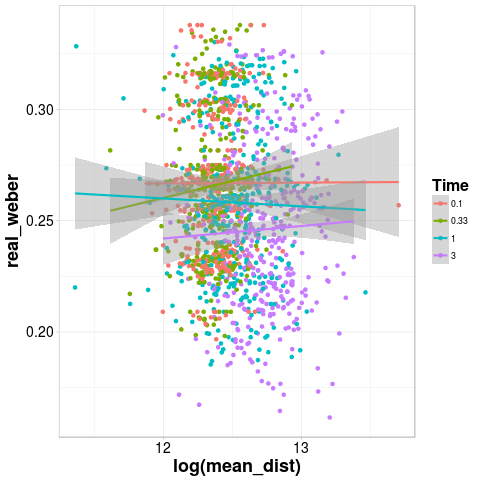

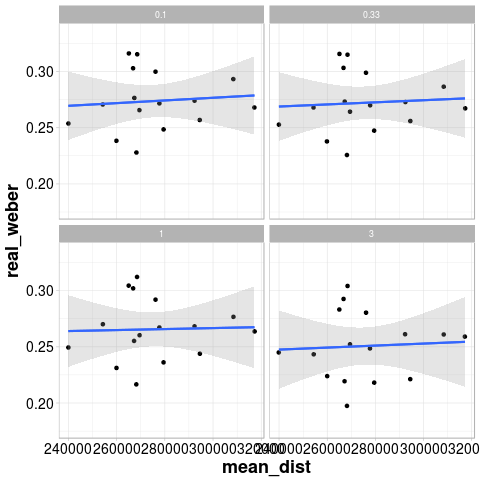

In [210]:
%%R -i sum_vals summary

sum_vals <- sum_vals %>%
            mutate(time_num=Time) %>%
          mutate(t=log(Time)) %>%
            mutate(Time=as.factor(Time)) %>%
            mutate(pct_seen=seen/Dots_Shown) %>%
           # mutate(t=Time) %>%
             mutate(real_weber=exp(pct_seen * seen_noise + noise)) %>%
             mutate(real_slope=exp(pct_seen * seen_slope + slope)) %>%
          #  mutate(real_weber=weber) %>%
          #  mutate(real_slope=slope) %>%

            mutate(guess=real_slope*Dots_Shown) %>%
            mutate(noise=real_weber*guess) %>%
            mutate(err=Dots_Counted - Dots_Shown) %>%
            mutate(pct_err=err/Dots_Shown)


sum_vals$unique_id <- seq.int(1,nrow(sum_vals))
print(nrow(sum_vals))
mean_reg_vals <- sum_vals %>%
                 group_by(pid) %>%
               # mutate(pct_seen=mean(pct_seen)) %>%
                mutate(fix_PL=mean(fix_PL)) %>%
              #  mutate(area=mean(area)) %>%
                mutate(pct_seen=mean(pct_seen)) %>%
                mutate(mean_dist = mean(mean_dist)) %>%

                  group_by(pid, Time) %>%
                # mutate(pct_seen=mean(pct_seen)) %>%

                  mutate(real_weber=mean(real_weber)) %>%
                 mutate(real_slope=mean(real_slope)) %>%
                mutate(mean_shown = mean(Dots_Shown)) %>%
              #  mutate(mean_dist=mean(dist)) %>%
                mutate(fix_PL=mean(fix_PL)) %>%
                mutate(area=mean(area)) %>%
                mutate(abs_err=mean(abs(pct_err))) %>%

                 mutate(pct_err=mean(pct_err)) %>%
               #  mutate(mean_area=mean(pct_area)) %>%
               #  mutate(mean_seen=mean(seen/Dots_Shown)) %>%
                 top_n(n=1, wt=unique_id)

p.1 <- ggplot(data=sum_vals, aes(x=log(mean_dist), y=real_weber, color=Time)) +
        geom_point() +
        stat_smooth(method="lm") +
        paper_theme_2 #+
        #facet_wrap(~Time)



p.2 <- ggplot(data=mean_reg_vals, aes(x=mean_dist, y=real_weber)) +
        geom_jitter() +
        stat_smooth(method="lm", se=FALSE) +
        stat_smooth(method="lm", alpha=0.25) +

        paper_theme_2 +
        facet_wrap(~Time)

print(p.1)
print(p.2)

#r.1 <- lm(data=subset(mean_reg_vals, mean_reg_vals$Time > 0.4), real_weber ~ log(fix_PL))
r.1 <- lm(data=mean_reg_vals, real_slope ~ area)
#r.2 <- lm(data=mean_reg_vals, real_weber ~ area*Time)

#print(summary(r.1))
#summary(r.2)

